IMPORT LIBRARY

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import img_to_array
import cv2
from sklearn.preprocessing import LabelBinarizer
import time

In [ ]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
label_binarizer = LabelBinarizer()
default_image_size = tuple((256, 256))     #image size 
FILE_PATH  = "/content/drive/MyDrive/dataplant/data"    #dir data 


READ DATASET

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 11603 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 7 7 2 7 5 3 6 9 5 1 5 6 5 6 0 6 1 5 9 5 7 9 5 0 3 9 9 1 5 0 6]


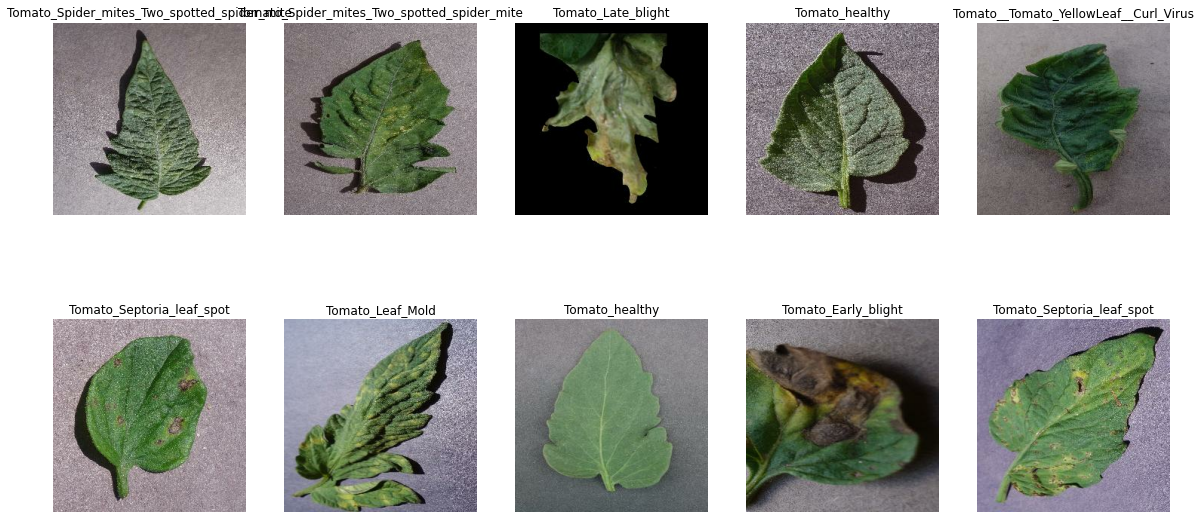

In [ ]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Pre-processing of the Dataset:

In [ ]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds

In [ ]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [ ]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

CNN structure

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

Training model with 20 epochs

In [ ]:
EPOCHS = 20
#model training
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/20
290/290 [==============================] - 3246s 1s/step - loss: 0.1052 - accuracy: 0.9666 - val_loss: 0.2027 - val_accuracy: 0.9332
Epoch 2/20
290/290 [==============================] - 28s 98ms/step - loss: 0.0851 - accuracy: 0.9713 - val_loss: 0.1641 - val_accuracy: 0.9427
Epoch 3/20
290/290 [==============================] - 27s 94ms/step - loss: 0.0871 - accuracy: 0.9694 - val_loss: 0.1527 - val_accuracy: 0.9497
Epoch 4/20
290/290 [==============================] - 27s 94ms/step - loss: 0.0826 - accuracy: 0.9710 - val_loss: 0.1709 - val_accuracy: 0.9523
Epoch 5/20
290/290 [==============================] - 27s 94ms/step - loss: 0.0934 - accuracy: 0.9672 - val_loss: 0.0914 - val_accuracy: 0.9748
Epoch 6/20
290/290 [==============================] - 27s 94ms/step - loss: 0.0936 - accuracy: 0.9679 - val_loss: 0.2183 - val_accuracy: 0.9453
Epoch 7/20
290/290 [==============================] - 27s 94ms/step - loss: 0.0706 - accuracy: 0.9759 - val_loss: 0.1381 - val_accuracy:

Training model with 30 epochs

In [ ]:
EPOCHS = 30
#model training
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/30
290/290 [==============================] - 2302s 1s/step - loss: 1.9367 - accuracy: 0.2943 - val_loss: 2.0112 - val_accuracy: 0.3021
Epoch 2/30
290/290 [==============================] - 29s 98ms/step - loss: 1.3915 - accuracy: 0.4995 - val_loss: 1.3847 - val_accuracy: 0.5165
Epoch 3/30
290/290 [==============================] - 29s 100ms/step - loss: 0.9852 - accuracy: 0.6466 - val_loss: 1.4310 - val_accuracy: 0.5382
Epoch 4/30
290/290 [==============================] - 29s 99ms/step - loss: 0.7785 - accuracy: 0.7218 - val_loss: 1.3300 - val_accuracy: 0.5712
Epoch 5/30
290/290 [==============================] - 29s 99ms/step - loss: 0.6938 - accuracy: 0.7435 - val_loss: 1.9604 - val_accuracy: 0.5148
Epoch 6/30
290/290 [==============================] - 29s 99ms/step - loss: 0.6128 - accuracy: 0.7796 - val_loss: 0.7966 - val_accuracy: 0.7188
Epoch 7/30
290/290 [==============================] - 28s 98ms/step - loss: 0.5309 - accuracy: 0.8100 - val_loss: 1.3164 - val_accuracy

Save model 20 epochs

In [ ]:
model.save('my_model.h5')

Load file model 

In [ ]:
model = keras.models.load_model("my_model.h5")

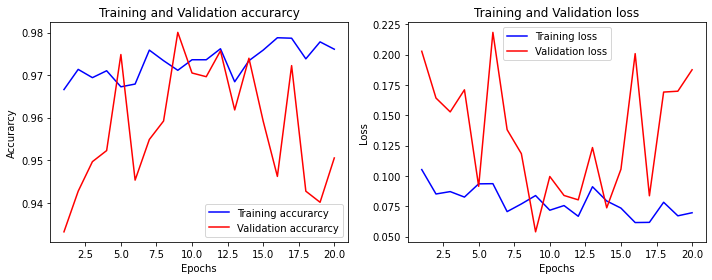

In [ ]:
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
ax1.plot(epochs, acc, 'b', label='Training accurarcy')
ax1.plot(epochs, val_acc, 'r', label='Validation accurarcy')
ax1.set_title('Training and Validation accurarcy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accurarcy')
ax1.legend()

#Train and validation loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
fig.tight_layout()

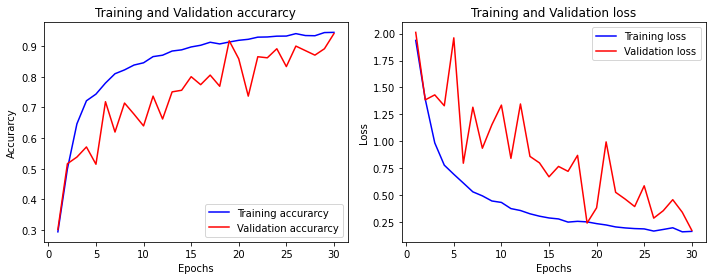

In [ ]:
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
ax1.plot(epochs, acc, 'b', label='Training accurarcy')
ax1.plot(epochs, val_acc, 'r', label='Validation accurarcy')
ax1.set_title('Training and Validation accurarcy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accurarcy')
ax1.legend()

#Train and validation loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
fig.tight_layout()

Predict model

first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 1s 664ms/step
predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


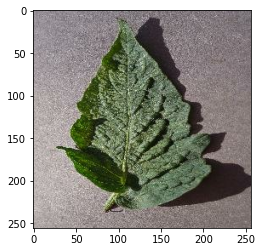

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


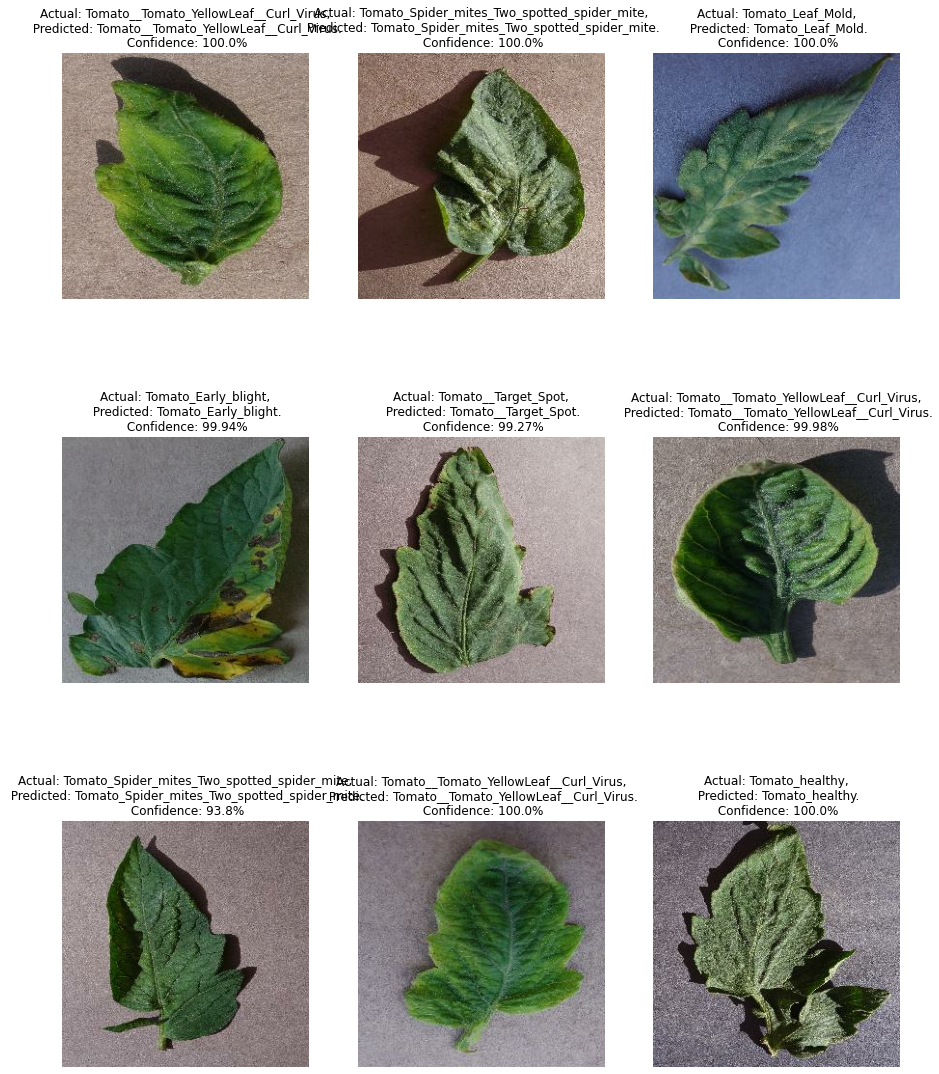

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

 model detection with onpencv video

1/1 [==============================] - 0s 89ms/step
probability:1.0
Tomato_Late_blight


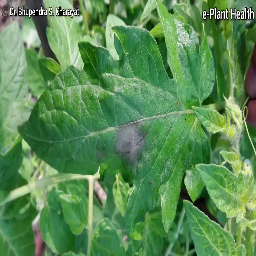

In [ ]:
from google.colab.patches import cv2_imshow

model = keras.models.load_model("/content/my_model.h5")
cap = cv2.VideoCapture('/content/tomato_Late_blight.mp4')
while(cap.isOpened()):
    if  model is not None:  
        success, img = cap.read()
        img = cv2.resize(img, default_image_size)
        a = img_to_array(img)
        a = np.array(a, dtype=np.float16) / 225.0
        tag = np.expand_dims(a, axis=0)
        result=model.predict(tag)   
        itemindex = np.where(result==np.max(result))
        print("probability:"+str(np.max(result))+"\n"+class_names[itemindex[1][0]])
        cv2_imshow(img)
        cap.release()
        cv2.destroyAllWindows()